# Seoul Hourly Bike Demand Prediction 

Whether you are looking for a short route nearby Seoul, or an end to end South Korea country-wide path, South Korea has both of them. South Korea has built massive cycling infrastructure in the past few decades, including a network of cross-country bike paths. Due to the high demand for bikes as a mode of transportation, Seoul City started a bike share program in 2015. 

There are more than a million trips per month from the program. Around the city, there are more than 1500 bike stations with about 20,000 bikes in operation according to 2021 data collected by Rutgers University. 

This project attempts to make predictions on what the count of hourly bike sharing demand will be for Seol city given features such as weather data and holiday information. The data was obtained from the UCI Machine Learning Repository. It has also been cited in a paper by Sathishkumar et. al. 

## Importing Dataset

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score, mean_squared_error 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [65]:
bike_df = pd.read_csv("seoulbikedata.csv", encoding="unicode_escape")
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Preprocessing

In [66]:
# remove the parenthesis in the features
bike_df.columns = bike_df.columns.str.replace(r"\([^)]+\)", "", regex=True)
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [67]:
# convert the column names to lower case and replace spaces with _
bike_df.columns = bike_df.columns.str.lower().str.rstrip(" ").str.replace(" ", "_")
bike_df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [68]:
# convert date to datetime object
bike_df.date = pd.to_datetime(bike_df.date)
#bike_df.info()

/tmp/ipykernel_439/1283928978.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  bike_df.date = pd.to_datetime(bike_df.date)


In [69]:
# convert all the string values to lower case and replace space
strings = list(bike_df.dtypes[bike_df.dtypes == "object"].index)
for col in strings:
    bike_df[col] = bike_df[col].str.lower().str.replace(" ", "_")
bike_df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,winter,no_holiday,yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,winter,no_holiday,yes


In [70]:
# extract year, month, weekday and dayofyear from date column
bike_df['year'] = bike_df.date.dt.year
bike_df['month'] = bike_df.date.dt.month
bike_df['day'] = bike_df.date.dt.day
bike_df['weekday'] = bike_df.date.dt.weekday
bike_df['daysofyear'] = bike_df.date.dt.dayofyear
bike_df.head() 

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,year,month,day,weekday,daysofyear
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,3,12
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,3,12
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,3,12
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,3,12
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,3,12


In [71]:
# map the weekdays to actual strings
weekdays_dict = {
    0: "monday", 
    1: "tuesday", 
    2: "wednesday", 
    3: "thursday",
    4: "friday", 
    5: "saturday",
    6: "sunday"
}
bike_df.weekday = bike_df.weekday.map(weekdays_dict)
bike_df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,year,month,day,weekday,daysofyear
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12


In [72]:
# remove the date columns
bike_df.drop("date", axis=1, inplace=True)
bike_df.head()

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,year,month,day,weekday,daysofyear
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,winter,no_holiday,yes,2017,1,12,thursday,12


In [73]:
# check for nulls and missing values
bike_df.isnull().sum()

rented_bike_count        0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
snowfall                 0
seasons                  0
holiday                  0
functioning_day          0
year                     0
month                    0
day                      0
weekday                  0
daysofyear               0
dtype: int64

There are no null values in the data set. As it is, it is set for exploratory data analysis. 

## Exploratory Data Analysis (EDA)

In [74]:
# what features are categorical and numerical?
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rented_bike_count      8760 non-null   int64  
 1   hour                   8760 non-null   int64  
 2   temperature            8760 non-null   float64
 3   humidity               8760 non-null   int64  
 4   wind_speed             8760 non-null   float64
 5   visibility             8760 non-null   int64  
 6   dew_point_temperature  8760 non-null   float64
 7   solar_radiation        8760 non-null   float64
 8   rainfall               8760 non-null   float64
 9   snowfall               8760 non-null   float64
 10  seasons                8760 non-null   object 
 11  holiday                8760 non-null   object 
 12  functioning_day        8760 non-null   object 
 13  year                   8760 non-null   int64  
 14  month                  8760 non-null   int64  
 15  day 

The categorical features are seasons, holiday, functioning_day and weekday, while the rest of the features are numerical. That's reasonable. 

In [75]:
# five number summary of the numerical features
bike_df.describe()

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,year,month,day,daysofyear
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,2017.915068,6.526027,15.720548,183.000000
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.278796,3.448048,8.796749,105.372043
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,1.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,2018.000000,4.000000,8.000000,92.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,2018.000000,7.000000,16.000000,183.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,2018.000000,10.000000,23.000000,274.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,2018.000000,12.000000,31.000000,365.000000


The standard deviation of the target, rented_bike_count, is very high. This could indicate a skewed distribution. That is also noticeable for visibility and days of the year. This is not a problem for days of the year except for visibility. 

Text(0.5, 1.0, 'Histogram of the target, rented_bike_count')

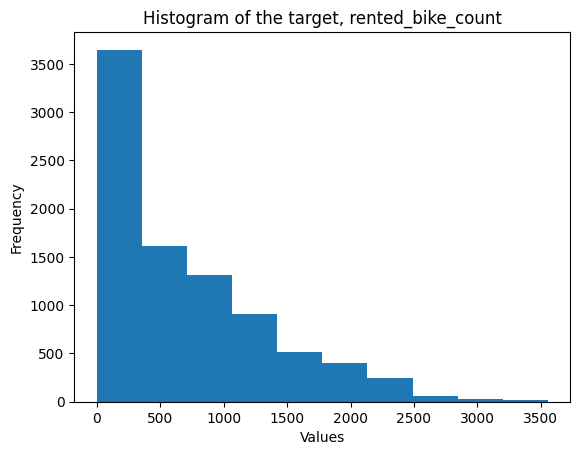

In [76]:
# a histogram of the target
plt.hist(bike_df.rented_bike_count)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of the target, rented_bike_count")

The target is a little skewed but it is not a long tailed distribution. So, there is no need to transform it. 

### Time_based Considerations

We'll look at the time based demand and see what insights we can derive from it

In [77]:
# hourly demand
hourly = bike_df.groupby("hour")["rented_bike_count"].sum()
hourly_df = hourly.to_frame()
hourly_df.reset_index(inplace=True)
hourly_df

,hour,rented_bike_count
0,0,197633
1,1,155557
2,2,110095
3,3,74216
4,4,48396
5,5,50765
6,6,104961
7,7,221192
8,8,370731
9,9,235784


Text(0.5, 1.0, 'Total Bike Demand Per Hour')

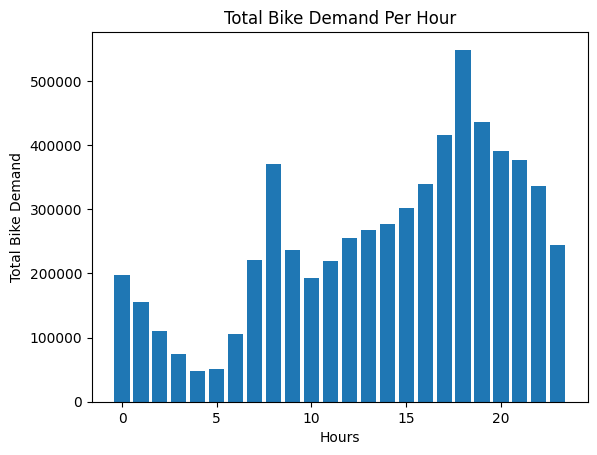

In [78]:
plt.bar(hourly_df.hour, hourly_df.rented_bike_count)
plt.xlabel("Hours")
plt.ylabel("Total Bike Demand")
plt.title("Total Bike Demand Per Hour")

We can see that bike rental demand is highest in the evening between 5 to 7 pm. Also, in the morning by 8 am there was significant demand. These are busy times for people going to work or offices and returning in the evening. There is also a noticeable demand at midnight. This demonstrtes the prevalence of night life in South Korea. 

In [79]:
# yearly demand
yearly = bike_df.groupby("year")["rented_bike_count"].sum()
yearly_df =  yearly.to_frame()
yearly_df.reset_index(inplace=True)
yearly_df

,year,rented_bike_count
0,2017,185330
1,2018,5986984


Text(0.5, 1.0, 'Total Bike Demand for 2017 and 2018')

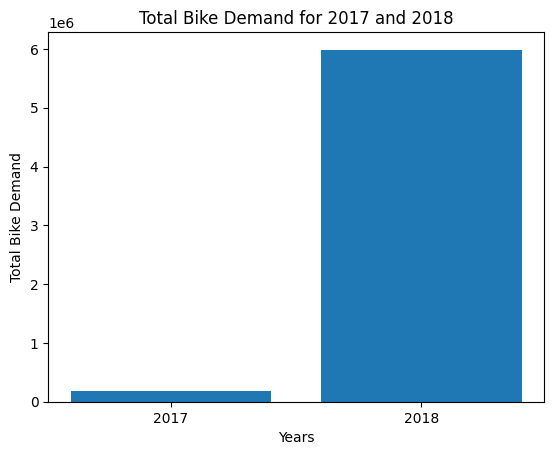

In [80]:
yearly_df.year = yearly_df.year.astype(str)
plt.bar(yearly_df.year, yearly_df.rented_bike_count)
plt.xlabel("Years")
plt.ylabel("Total Bike Demand")
plt.title("Total Bike Demand for 2017 and 2018")

We can see that the total demand in 2018 is about 50 times more than that of 2017. These are the two years covered by the data. The researcher has no domain knowledge for why this is so. 

In [81]:
# monthly demand
monthly = bike_df.groupby("month")["rented_bike_count"].sum()
monthly_df = monthly.to_frame()
monthly_df.reset_index(inplace=True)
months_map = {
    1: "January", 
    2: "February", 
    3: "March", 
    4: "April", 
    5: "May", 
    6: "June", 
    7: "July", 
    8: "August", 
    9: "September", 
    10: "October", 
    11: "November", 
    12: "December"
}
monthly_df.month = monthly_df.month.map(months_map)
monthly_df

,month,rented_bike_count
0,January,287244
1,February,264112
2,March,455037
3,April,556219
4,May,665948
5,June,706728
6,July,691339
7,August,614190
8,September,499326
9,October,626988


Text(0.5, 1.0, 'Total BIke Demand By Months')

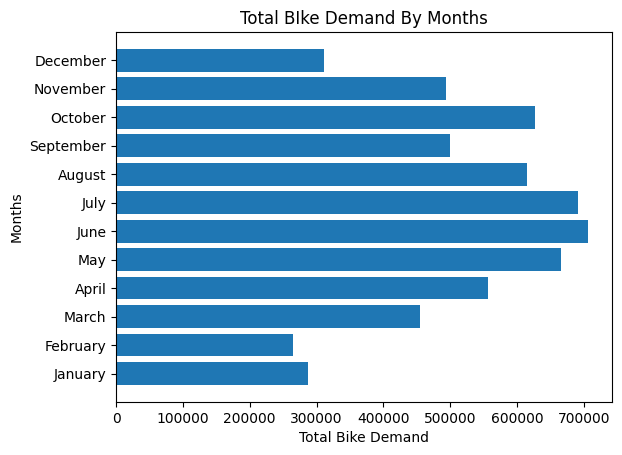

In [82]:
plt.barh(monthly_df.month, monthly_df.rented_bike_count)
plt.ylabel("Months")
plt.xlabel("Total Bike Demand")
plt.title("Total BIke Demand By Months")

We see that May, June, July and October have higher bike rental demand than other months. This corresponds to the summer and autumn seasons which are when people are most active. 

In [83]:
# seasonal demand
seasonal = bike_df.groupby("seasons")["rented_bike_count"].sum()
seasonal_df = seasonal.to_frame()
seasonal_df.reset_index(inplace=True)
seasonal_df

,seasons,rented_bike_count
0,autumn,1790002
1,spring,1611909
2,summer,2283234
3,winter,487169


Text(0.5, 1.0, 'Total Bike Demand According To The Seasons')

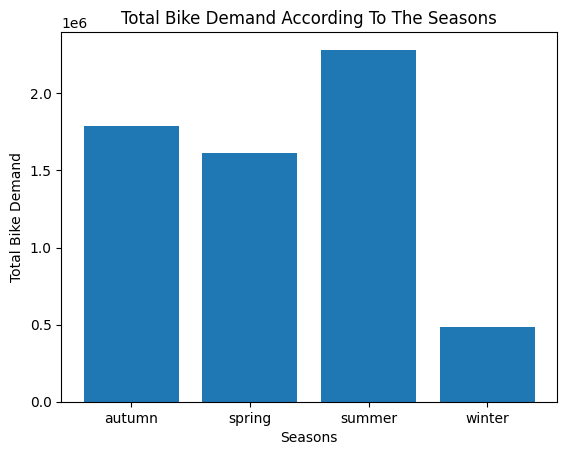

In [84]:
plt.bar(seasonal_df.seasons, seasonal_df.rented_bike_count)
plt.xlabel("Seasons")
plt.ylabel("Total Bike Demand")
plt.title("Total Bike Demand According To The Seasons")

We find that the highest bike rental demand is for the summer months followed by autumn. This confirms the results from the monthly demand charet. 

What if we find out if there are differences in demand per the holidays?

In [85]:
# holiday demand
holidays = bike_df.groupby("holiday")["rented_bike_count"].sum()
holidays_df = holidays.to_frame()
holidays_df.reset_index(inplace=True)
holidays_df

,holiday,rented_bike_count
0,holiday,215895
1,no_holiday,5956419


Text(0.5, 1.0, 'Total Bike Demand Based on Holiday or Non-holidays')

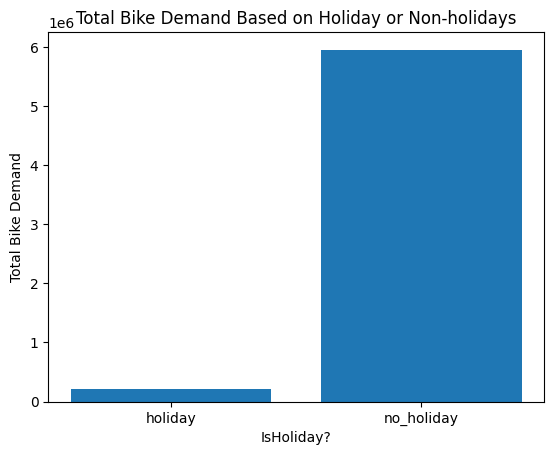

In [86]:
plt.bar(holidays_df.holiday, holidays_df.rented_bike_count)
plt.xlabel("IsHoliday?")
plt.ylabel("Total Bike Demand")
plt.title("Total Bike Demand Based on Holiday or Non-holidays")

We believe there is a skew in this data. This is because the holiday seasons are not many in the year while the non-holidays are significant in the year. So, this does not show a good comparison. But it would be more relevant when building a model. 

In [87]:
# week of the day
weekly = bike_df.groupby("weekday")["rented_bike_count"].sum()
weekly_df = weekly.to_frame()
weekly_df.reset_index(inplace=True)
# let's rearrange the days
rearranged = [1, 5, 6, 4, 0, 2, 3]
weekly_df = weekly_df.reindex(rearranged)
weekly_df.reset_index(drop=True, inplace=True)
weekly_df

,weekday,rented_bike_count
0,monday,863563
1,tuesday,862877
2,wednesday,908871
3,thursday,928267
4,friday,898966
5,saturday,911475
6,sunday,798295


Text(0.5, 1.0, 'Total Bike Demand For Each Day Of The Week')

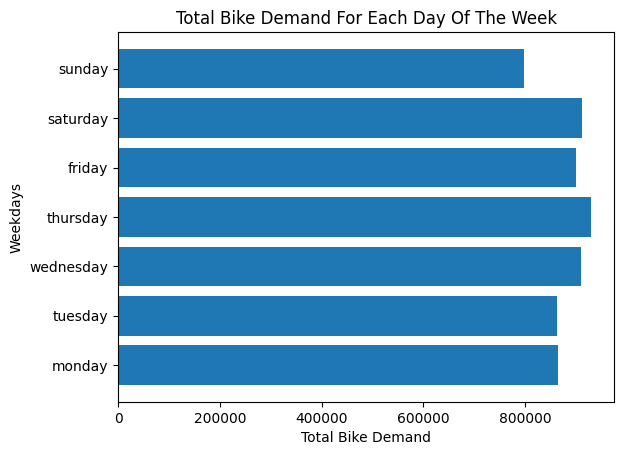

In [88]:
plt.barh(weekly_df.weekday, weekly_df.rented_bike_count)
plt.ylabel("Weekdays")
plt.xlabel("Total Bike Demand")
plt.title("Total Bike Demand For Each Day Of The Week")

We see that from Wednesday to Saturday, there is higher demand for bikes with the peak on Thursday. 

## Feature Importance and Feature Selection

I will use the mutual information score to calculate the similarity between the categorical features and the target. Higher mutual information scores for a feature suggests it has good predictive powers for the target. 

In [89]:
# getting all the categorical features 
categorical_list = list(bike_df.dtypes[bike_df.dtypes == "object"].index)
scores_list = []
for feature in categorical_list:
    mi_score = mutual_info_score(bike_df.rented_bike_count, bike_df[feature])
    scores_list.append((feature, mi_score))
scores_df = pd.DataFrame(scores_list, columns=["feature", "mi_score"])
scores_df.sort_values(by="mi_score", ascending=False, inplace=True)
scores_df   


,feature,mi_score
3,weekday,0.725642
0,seasons,0.592849
2,functioning_day,0.147296
1,holiday,0.073755


Based on the mutual information score for the categorical variables, we might assume that the holiday feature doesn't have much predictive power for the target, that is bike demand. According to the EDA, days where there are holidays have very low total demand and the classes are imbalanced for that feature because most of the days are not holidays in a year. We'll test this assumption out when creating the base model. 

I will now use correlation coefficients to find out how the numerical features correlate with the target. 

In [90]:
# get a dataframe containing only the numeric features
all_list = bike_df.columns
numerical_list = []
for col in all_list:
    if col not in categorical_list and col != "rented_bike_count":
        numerical_list.append(col)
numeric_df = bike_df[numerical_list]
        



In [91]:
# calculate the correlation with the target
correlations = numeric_df.corrwith(bike_df.rented_bike_count)
correlations = correlations.to_frame()
correlations.reset_index(inplace=True)
correlations.columns = ["Features", "Correlation_Coefficient"]
correlations.Correlation_Coefficient = abs(correlations.Correlation_Coefficient)
correlations.sort_values(by="Correlation_Coefficient", ascending=False, inplace=True)
correlations

,Features,Correlation_Coefficient
1,temperature,0.538558
0,hour,0.410257
5,dew_point_temperature,0.379788
6,solar_radiation,0.261837
9,year,0.215162
2,humidity,0.199780
4,visibility,0.199280
8,snowfall,0.141804
7,rainfall,0.123074
3,wind_speed,0.121108


It is suggested based on the correlation coefficients that the features - daysofyear, month and day - might not have predictive importance with the target variable. Will check them out while doing the baseline model. 

## Baseline Model

In [92]:
# train test split
train_df, val_df = train_test_split(bike_df, test_size=0.20, random_state=42)



In [93]:
# extract the targets
y_train = train_df.rented_bike_count.values 
y_val = val_df.rented_bike_count.values

In [94]:
# drop the target from the data
train_df.drop("rented_bike_count", axis=1, inplace=True)
val_df.drop("rented_bike_count", axis=1, inplace=True)

In [95]:
# one hot encoding for the categorical features
dv = DictVectorizer(sparse=False)
train_dict = train_df.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = val_df.to_dict(orient="records")
X_val = dv.transform(val_dict) 


In [96]:
# creating the baseline model using linear regression model
baseline_model = LinearRegression().fit(X_train, y_train)


In [97]:
# make prediction on the validation data
y_pred = baseline_model.predict(X_val)

In [98]:
# assess the performance of the baseline model
rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_score

439.12973947899343

Now that we have a baseline rmse score, let's see if removing the features that were detected to have low predictive value would improve the model. If they do, then it would be better working without those features. 

In [99]:
low_value_features = ["holiday", "daysofyear", "month", "day"]
train_reduced_df = train_df.copy()
train_reduced_df.drop(low_value_features, axis=1, inplace=True)
val_reduced_df = val_df.copy()
val_reduced_df.drop(low_value_features, axis=1, inplace=True)

In [100]:
# one hot encoding for the categorical features
dv2 = DictVectorizer(sparse=False)
train_dict = train_reduced_df.to_dict(orient="records")
X_train = dv2.fit_transform(train_dict)

val_dict = val_reduced_df.to_dict(orient="records")
X_val = dv2.transform(val_dict) 


In [101]:
# creating the reduced features baseline model
baseline_model2 = LinearRegression().fit(X_train, y_train)
# make prediction on the validation data
y_pred2 = baseline_model2.predict(X_val)
# assess the performance of the reduced baseline model
rmse_score2 = np.sqrt(mean_squared_error(y_val, y_pred2))
rmse_score2


439.95907731720473

So removing those features made the RMSE score higher. So, we will keep the features and use the data for the baseline model. 

In [102]:
f'The baseline model is {rmse_score}'

'The baseline model is 439.12973947899343'

## Training the data on several models

In [103]:
# dict vectorizer for the trains and vals dataset
dv = DictVectorizer(sparse=False)
train_dict = train_df.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = val_df.to_dict(orient="records")
X_val = dv.transform(val_dict) 


In [104]:
# scaling both data sets in case of outliers and to optimize the models
scaler = StandardScaler()
# Create scaled version of the predictors
X_scaled = scaler.fit_transform(X_train)
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=dv.get_feature_names_out())
X_standardise.head()

,day,daysofyear,dew_point_temperature,functioning_day=no,functioning_day=yes,holiday=holiday,holiday=no_holiday,hour,humidity,month,...,visibility,weekday=friday,weekday=monday,weekday=saturday,weekday=sunday,weekday=thursday,weekday=tuesday,weekday=wednesday,wind_speed,year
0,0.031056,1.304289,0.130553,-0.187089,0.187089,-0.229967,0.229967,0.505421,0.137012,1.301465,...,-1.176113,2.490475,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,-0.412723,2.092940,0.301793
1,1.508525,-0.025408,1.255469,-0.187089,0.187089,-0.229967,0.229967,-0.363566,1.359982,-0.149484,...,-1.472667,2.490475,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,-0.412723,-0.029683,0.301793
2,-0.082595,1.294791,-0.316331,-0.187089,0.187089,-0.229967,0.229967,1.084745,-0.596770,1.301465,...,-0.930350,-0.401530,-0.395037,-0.411065,-0.420037,2.465520,-0.411539,-0.412723,-0.319131,0.301793
3,-1.560064,-1.421588,-0.894198,-0.187089,0.187089,-0.229967,0.229967,1.664070,0.528362,-1.310243,...,-0.004643,2.490475,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,-0.412723,0.259766,0.301793
4,0.258359,0.155051,1.371043,-0.187089,0.187089,-0.229967,0.229967,1.519239,0.724038,0.140706,...,-0.707525,-0.401530,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,2.422930,-0.222648,0.301793


In [105]:
# scaling validation dataset
val_scaled = scaler.transform(X_val)
val_standardise = pd.DataFrame(val_scaled, columns=dv.get_feature_names_out())
val_standardise.head()

,day,daysofyear,dew_point_temperature,functioning_day=no,functioning_day=yes,holiday=holiday,holiday=no_holiday,hour,humidity,month,...,visibility,weekday=friday,weekday=monday,weekday=saturday,weekday=sunday,weekday=thursday,weekday=tuesday,weekday=wednesday,wind_speed,year
0,-0.878155,0.933873,1.301699,-0.187089,0.187089,-0.229967,0.229967,-0.508397,0.528362,1.011275,...,0.921064,-0.401530,2.531409,-0.411065,-0.420037,-0.405594,-0.411539,-0.412723,0.066800,0.301793
1,0.485662,0.174047,1.309403,-0.187089,0.187089,-0.229967,0.229967,0.070928,-0.352176,0.140706,...,-1.043401,2.490475,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,-0.412723,0.356249,0.301793
2,-0.878155,0.060073,1.386452,-0.187089,0.187089,-0.229967,0.229967,0.360590,-0.401095,0.140706,...,0.503267,-0.401530,-0.395037,-0.411065,2.380743,-0.405594,-0.411539,-0.412723,-0.512097,0.301793
3,0.031056,1.009856,0.107439,-0.187089,0.187089,-0.229967,0.229967,0.939914,-0.547852,1.011275,...,0.327956,-0.401530,-0.395037,-0.411065,-0.420037,-0.405594,2.429904,-0.412723,-0.319131,0.301793
4,0.258359,-0.709251,-0.547478,-0.187089,0.187089,-0.229967,0.229967,-0.653228,-0.352176,-0.729864,...,-0.063626,-0.401530,-0.395037,-0.411065,-0.420037,-0.405594,-0.411539,2.422930,-0.705063,0.301793


Will now create a loop that fits all the selected models and then makes the prediction instantly. After that, the predictions will be assessed. 

In [106]:
# creating a loop
models_list = ["Linear Regression", "Ridge Regression", "Lasso Regression",
    "Support Vector Regressor", "K Nearest Neighbor", "AdaBoost Regressor", 
    "Decision Tree Regressor","Random Forest Regressor"]
model_instance = [
    LinearRegression(), 
    Ridge(random_state=42),
    Lasso(alpha=0.01, random_state=42),
    SVR(C=1.0, epsilon=0.2),
    KNeighborsRegressor(),
    AdaBoostRegressor(random_state=42, n_estimators=100),
    DecisionTreeRegressor(random_state=42, max_depth=5),
    RandomForestRegressor(max_depth=2, random_state=42)        
] 

In [107]:
# function call goes through each model and makes a prediction
results = []
for i in tqdm(range(len(models_list))):
    # take each model one after the other
    print(f'Training {models_list[i]}...')
    model = model_instance[i].fit(X_standardise, y_train)
    print(f'Predicting {models_list[i]}...')
    y_predict = model.predict(val_standardise)
    print(f'Assessing {models_list[i]}...')
    rmse = np.sqrt(mean_squared_error(y_val, y_predict))
    results.append((models_list[i], rmse))
    print("FINISHED...")
    print("\n")
results_df = pd.DataFrame(results, columns=["models", "rmse"])
    

  0%|          | 0/8 [00:00<?, ?it/s]

Training Linear Regression...


 25%|██▌       | 2/8 [00:01<00:03,  1.83it/s]

Predicting Linear Regression...
Assessing Linear Regression...
FINISHED...


Training Ridge Regression...
Predicting Ridge Regression...
Assessing Ridge Regression...
FINISHED...


Training Lasso Regression...


/home/emekadavid2/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e+08, tolerance: 2.914e+05
  model = cd_fast.enet_coordinate_descent(
 38%|███▊      | 3/8 [00:01<00:02,  1.77it/s]

Predicting Lasso Regression...
Assessing Lasso Regression...
FINISHED...


Training Support Vector Regressor...
Predicting Support Vector Regressor...


 50%|█████     | 4/8 [00:10<00:14,  3.70s/it]

Assessing Support Vector Regressor...
FINISHED...


Training K Nearest Neighbor...
Predicting K Nearest Neighbor...


 62%|██████▎   | 5/8 [00:10<00:07,  2.58s/it]

Assessing K Nearest Neighbor...
FINISHED...


Training AdaBoost Regressor...


 75%|███████▌  | 6/8 [00:13<00:05,  2.52s/it]

Predicting AdaBoost Regressor...
Assessing AdaBoost Regressor...
FINISHED...


Training Decision Tree Regressor...
Predicting Decision Tree Regressor...
Assessing Decision Tree Regressor...
FINISHED...


Training Random Forest Regressor...


100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

Predicting Random Forest Regressor...
Assessing Random Forest Regressor...
FINISHED...




In [108]:
results_df.sort_values(by="rmse", inplace=True)
results_df

,models,rmse
4,K Nearest Neighbor,349.522889
6,Decision Tree Regressor,353.022664
0,Linear Regression,439.218683
1,Ridge Regression,439.486368
2,Lasso Regression,439.534598
5,AdaBoost Regressor,440.719476
7,Random Forest Regressor,488.765853
3,Support Vector Regressor,574.830970


Right now, K Nearest Neighbor and Decision Tree Regressors seems to be the best estimators. There is one more to try, that is, XGBoost algorithm before making a final conclusion on what model to tune its hyperparameter. 

In [109]:
# setting up xgboost regressor
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_standardise, label=y_train, feature_names=features)
dval = xgb.DMatrix(val_standardise, label=y_val, feature_names=features)

In [110]:
xgb_params = {'seed': 1, 'verbosity': 2}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[09:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[09:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[09:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[09:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[09:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[09:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[09:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[09:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[09:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 p

In [111]:
y_pred = model.predict(dval)

In [112]:
# assessing the default model and adding it to other results
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
new_result = {'models': "XGBoost Regressor", "rmse": rmse} 
results_df = results_df.append(new_result, ignore_index=True)
results_df.sort_values(by="rmse", inplace=True)
results_df

/tmp/ipykernel_439/1601246159.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_result, ignore_index=True)


,models,rmse
8,XGBoost Regressor,244.523133
0,K Nearest Neighbor,349.522889
1,Decision Tree Regressor,353.022664
2,Linear Regression,439.218683
3,Ridge Regression,439.486368
4,Lasso Regression,439.534598
5,AdaBoost Regressor,440.719476
6,Random Forest Regressor,488.765853
7,Support Vector Regressor,574.830970


So it is clear that the XGBoost regressor is the best model by a far distance. 

Let us visually see the plot of the predicted train data and the unseen validation data. 

In [113]:
# first evaluating the train rmse
train_prediction = model.predict(dtrain)
train_rmse = np.sqrt(mean_squared_error(y_train, train_prediction))
train_rmse

201.28432079227107

The train rmse is not too far from the unseen validation rmse. So there is no question of overfitting from this result. 

The next step is to tune the hyperparameters of xgboost algorithm, so we will get the best prediction from it. 

### Hyperparameter tuning of xgboost model

There are lots of hyperparameters to tune in XGBoost, so be patient. We will concentrate on 6 hyperparameters that usually have a big impact on performance. 

In [114]:
# the params dictionary
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
# number of trees to build will be retuned each time. We initially make it large
num_boost_round = 999
# ready to train the model but we set early stopping rounds to a low value
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10
)

[09:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	Validation-rmse:712.36186
[09:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	Validation-rmse:546.71608
[09:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	Validation-rmse:437.65458
[09:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	Validation-rmse:366.22491
[09:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[4]	Validation-rmse:320.08118
[09:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[5]	Validation-rmse:293.54430
[09:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[6]	Validation-rmse:275

We can see that at the 120th boosting, we achieved a better rmse of 192.51994. But a lot needs to be done. This is better than just boosting with arbitrary number of trees. This rmse is the default parameters. Let's continue.  

To hyperparameter tune, we will use XGBoost's cross validation function. We will also seed the process for reproducibility. We will use 5 folds cross validation and the rmse metric during cross validation. 

In [115]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

[09:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[09:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[09:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[09:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[09:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[09:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[09:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[09:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[09:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 p

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,704.836185,1.029944,705.914284,5.895905
1,533.564034,0.908404,536.737740,6.891524
2,418.851619,0.697572,425.481883,6.865128
3,343.142214,0.880750,353.478365,7.101827
4,293.211253,1.600289,308.561674,7.430227
...,...,...,...,...
187,38.154646,0.891244,183.325628,4.608686
188,37.846167,0.924029,183.312470,4.597462
189,37.586011,0.905415,183.236969,4.620209
190,37.437542,0.934111,183.225638,4.626970


From the cross validation table, we see that we stopped at the 192nd round with a lower test rmse mean score. 

In [116]:
cv_results['test-rmse-mean'].min()

183.14111338937283

We are now ready to start tuning. 

We tuned the hyperparameters in the params grid.

First, tuning max_depth and min_child_weight. max_depth is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper models can cause overfitting. min_child_weight is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. More samples can cause overfitting. 

subsample corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

colsample_bytree corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

Finally, we tuned the learning rate or eta. A lower eta makes our model more robust to overfitting. The lower the learning rate or eta, the best. We'll try a range of values here.

All these was done on Google colab because the tuning process is computationally intensive. To see the procedure used, consult the references below. 

After successful tuning, our params dictionary became as outlined below.

In [117]:
params = {'max_depth': 7,
 'min_child_weight': 6,
 'eta': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'objective': 'reg:squarederror'}

In [118]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10
)
print("Best RMSE: {} in {} rounds".format(model.best_score, model.best_iteration+1))

[09:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	Validation-rmse:917.97068
[09:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=7
[1]	Validation-rmse:884.53960
[09:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	Validation-rmse:847.18047
[09:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=7
[3]	Validation-rmse:810.81301
[09:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=7
[4]	Validation-rmse:780.75895
[09:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=7
[5]	Validation-rmse:748.93796
[09:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=7
[6]	Validation-rmse:71

So you can see that we improved our RMSE score from 244 to 171. That's a very good improvement with hyperparameter tuning. 

# Final Model

To get the final model, we train our model on all the data. The more data we have, the better the results from prediction on unseen or future values. 

In [119]:
y_full = bike_df.rented_bike_count.values 
X_full = bike_df.drop("rented_bike_count", axis=1)

In [120]:
# dictvectorize and scale the full data
dicts_full_train = X_full.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full = dv.fit_transform(dicts_full_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
X_standardise = pd.DataFrame(X_scaled,columns=dv.get_feature_names_out())
X_standardise.head()


,day,daysofyear,dew_point_temperature,functioning_day=no,functioning_day=yes,holiday=holiday,holiday=no_holiday,hour,humidity,month,...,visibility,weekday=friday,weekday=monday,weekday=saturday,weekday=sunday,weekday=thursday,weekday=tuesday,weekday=wednesday,wind_speed,year
0,-0.42297,-1.622914,-1.659605,-0.18668,0.18668,-0.227757,0.227757,-1.661325,-1.042483,-1.602745,...,0.925871,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,0.458476,-3.282407
1,-0.42297,-1.622914,-1.659605,-0.18668,0.18668,-0.227757,0.227757,-1.516862,-0.993370,-1.602745,...,0.925871,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.892561,-3.282407
2,-0.42297,-1.622914,-1.667262,-0.18668,0.18668,-0.227757,0.227757,-1.372399,-0.944257,-1.602745,...,0.925871,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.699556,-3.282407
3,-0.42297,-1.622914,-1.659605,-0.18668,0.18668,-0.227757,0.227757,-1.227936,-0.895144,-1.602745,...,0.925871,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.796059,-3.282407
4,-0.42297,-1.622914,-1.736177,-0.18668,0.18668,-0.227757,0.227757,-1.083473,-1.091596,-1.602745,...,0.925871,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,0.554978,-3.282407


In [121]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_standardise, label=y_full, feature_names=features)


In [122]:
model = xgb.train(params, dtrain, num_boost_round=537)

[09:08:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=7
[09:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 

## References
1. Seoul Bike Sharing Dataset UCI page: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

2. Cited papers: Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020

3. Hyperparameter tuning in XGBoost. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f